In [1]:
import numpy as np

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.optim import Adam
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

from sklearn.preprocessing import StandardScaler

# Binary category

In [2]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv"

df = pd.read_csv(url, sep=";")[['male', 'height']]
df.head()

,male,height
0,1,151.765
1,0,139.700
2,0,136.525
3,1,156.845
4,0,145.415


Model:
$$\begin{align}
h_i ∼& \;\text{Normal}(\mu_i , \sigma) \\
\mu_i =& \; \alpha_{\text{male[i]} } \\
\alpha_j ∼& \; \text{Normal}(178, 20) \quad \text{for j = 1..2} \\
\sigma ∼& \; \text{Uniform}(0, 50)
\end{align}$$

In [3]:
def model(male, height):
    a = numpyro.sample("a", dist.Normal(178, 20).expand((2,)) )
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[male]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, Adam(1), ELBO(),
          male=df['male'].values,
          height=df['height'].values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
param = svi.get_params(state)
post = guide.sample_posterior(PRNGKey(1), param, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



In [4]:
post = guide.sample_posterior(PRNGKey(1), param, (1000,))
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



# Multiple category

In [5]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/milk.csv"

df = pd.read_csv(url, sep=";")
df['clade'] = df['clade'].astype("category")
df["clade_id"] = df['clade'].cat.codes
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,3


In [6]:
scaler = StandardScaler().fit(df[['kcal.per.g']])
df['K'] = scaler.transform(df[['kcal.per.g']])

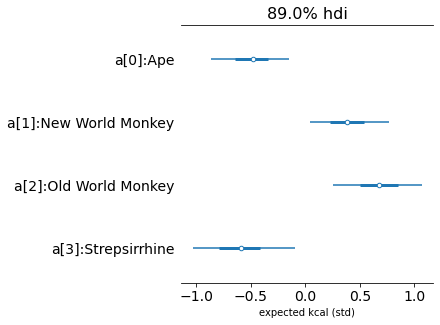

In [7]:
def model(clade_id, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand((4,)))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)


guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide,
          Adam(1), ELBO(),
          clade_id=df['clade_id'].values,
          K=df['K'].values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
param = svi.get_params(state)
post = guide.sample_posterior(PRNGKey(1), param, (1000,))


labels = [f"a[{i}]:{s}" for i, s in enumerate(df['clade'].cat.categories)]
az.plot_forest({"a": [post["a"]]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1],
              xlabel="expected kcal (std)")
plt.show()